In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import time

class IntervalGraph:
    def __init__(self, intervals, adj_list):
        self.intervals = intervals
        self.adj_list = adj_list
        
    def do_intersect(self, interval1, interval2):
        """
        Проверяет пересечение двух интервалов.
        """
        return interval1[0] <= interval2[1] and interval2[0] <= interval1[1]

def generate_intervals(n, length):
    intervals = []
    for _ in range(n):
        start = random.uniform(0, length - 1)
        end = start + random.uniform(1, 3)
        intervals.append((start, end))

    # Генерация случайного дерева
    tree_edges = [(0, random.randint(1, n-1))]
    for i in range(2, n):
        tree_edges.append((i, random.randint(0, i-1)))

    # Создание связного графа из дерева
    adj_list = {i: set() for i in range(n)}
    for edge in tree_edges:
        u, v = edge
        adj_list[u].add(v)
        adj_list[v].add(u)

    # Добавление недостающих ребер для связности
    for i in range(n):
        if len(adj_list[i]) == 1:
            j = random.choice(list(set(range(n)) - {i}))
            adj_list[i].add(j)
            adj_list[j].add(i)

    # Генерация интервальных графов
    graph = IntervalGraph(intervals, adj_list)

    return graph

Алгоритм полного перебора

In [2]:
def find_longest_path_BF(graph):
    longest_path = []
    longest_length = 0
    iteration = 0
    max_iterations = 20000000000  # Максимальное количество итераций для большего контроля над проектом

    # Генерация всех возможных путей
    for path in itertools.permutations(range(len(graph.intervals))):
        iteration += 1

        # Проверка, является ли путь допустимым
        valid = True
        for i in range(len(path) - 1):
            if path[i + 1] not in graph.adj_list[path[i]]:
                valid = False
                break

        if valid:
            # Рассчитываем длину пути
            path_length = sum(graph.intervals[i][1] - graph.intervals[i][0] for i in path)
            # Обновляем самый длинный путь
            if path_length > longest_length:
                longest_path = path
                longest_length = path_length

        # Проверяем количество выполненных итераций
        if iteration >= max_iterations:
            print("Reached maximum number of iterations")
            break

    return longest_path, longest_length

Для полного перебора другая генерация графа из-за стоимости метода, на 14+ вершинах он выполняется >2 часов

Метод обхода в глубину

In [3]:
def longest_path_dfs(graph):
    visited = set()
    max_path = []

    def dfs(node, path):
        nonlocal max_path
        visited.add(node)
        for neighbor in graph.adj_list[node]:
            if neighbor not in visited:
                dfs(neighbor, path + [neighbor])
        if len(path) > len(max_path):
            max_path = path

    for node in range(len(graph.intervals)):
        if node not in visited:
            dfs(node, [node])

    return max_path

Метод ветвей и границ

In [4]:
def lower_bound_2(graph, current_path, intersection_cache):
    """
    Функция для вычисления нижней оценки длины пути.
    """
    current_length = sum(graph.intervals[node][1] - graph.intervals[node][0] for node in current_path)

    # Проверяем каждый интервал
    for node in range(len(graph.intervals)):
        if node not in current_path:
            if node in intersection_cache:
                # Используем кэш, если интервал уже был проверен
                intersect = intersection_cache[node]
            else:
                intersect = False
                for path_node in current_path:
                    if graph.do_intersect(graph.intervals[node], graph.intervals[path_node]):
                        intersect = True
                        break
                # Сохраняем результат в кэше
                intersection_cache[node] = intersect

            if intersect:
                current_length += graph.intervals[node][1] - graph.intervals[node][0]

    return current_length

def branch_and_bound_2(graph):
    """
    Функция для поиска самого длинного пути в интервальном графе методом ветвей и границ.
    """
    best_path = []
    best_length = 0
    current_path = []
    current_length = 0
    visited = set()
    intersection_cache = {}  # Инициализация кэша пересечений

    def dfs(node):
        nonlocal current_path, current_length, best_path, best_length
        visited.add(node)
        current_path.append(node)
        current_length += graph.intervals[node][1] - graph.intervals[node][0]

        # Обновление лучшего пути, если текущий путь длиннее
        if current_length > best_length:
            best_path = current_path[:]
            best_length = current_length

        # Перебор соседних вершин
        for neighbor in graph.adj_list[node]:
            if neighbor not in visited:
                # Проверка нижней оценки длины пути
                if current_length + lower_bound_2(graph, current_path + [neighbor], intersection_cache) > best_length:
                    dfs(neighbor)

        # Возврат к предыдущей вершине
        visited.remove(node)
        current_path.pop()
        current_length -= graph.intervals[node][1] - graph.intervals[node][0]

    # Начинаем обход с каждой вершины графа
    for node in range(len(graph.intervals)):
        dfs(node)

    return best_path, best_length

Жадный алгоритм

In [5]:
def greedy_longest_path_2(graph):
    longest_path = []
    longest_length = 0
    
    # Итерация по каждой вершине графа
    for start_node in range(len(graph.intervals)):
        current_path = [start_node]  # Начинаем путь с текущей вершины
        current_length = 1
        
        visited = set()  # Множество посещенных вершин
        visited.add(start_node)
        
        # Продолжаем двигаться к соседним вершинам, выбирая вершину с наибольшей степенью, пока возможно
        while True:
            max_degree_node = None
            max_degree = 0
            
            # Поиск следующей вершины с наибольшей степенью
            for neighbor in graph.adj_list[current_path[-1]]:
                if neighbor not in visited:
                    degree = len(graph.adj_list[neighbor])
                    if degree > max_degree:
                        max_degree = degree
                        max_degree_node = neighbor
            
            # Если найдена следующая вершина, добавляем ее в путь и обновляем длину пути
            if max_degree_node is not None:
                current_path.append(max_degree_node)
                current_length += 1
                visited.add(max_degree_node)
            else:
                break
            
        # Обновляем самый длинный путь и его длину, если текущий путь длиннее
        if current_length > longest_length:
            longest_path = current_path
            longest_length = current_length
    
    return longest_path, longest_length


Теперь сгенерируем граф для метода полного перебора и решим для него задачу

In [6]:
num_intervals = random.randint(9, 10)
graph = generate_intervals(num_intervals, 10)

Самый длинный путь:
(2, 1, 3, 8, 0, 4, 5, 7, 6, 9)
Длина самого длинного пути:
21.870376085704418


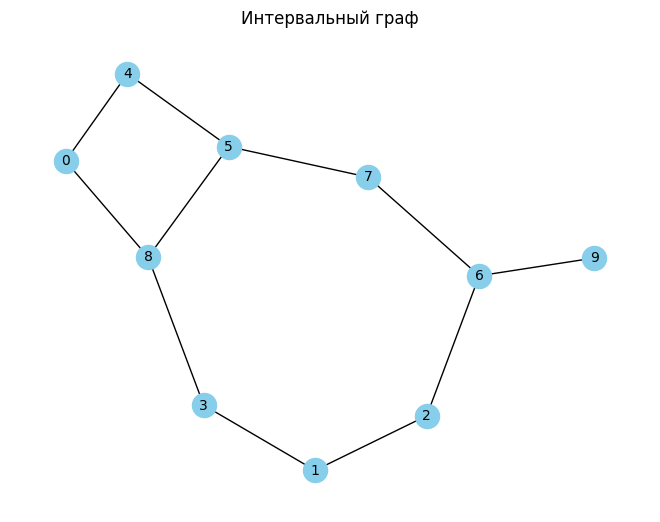

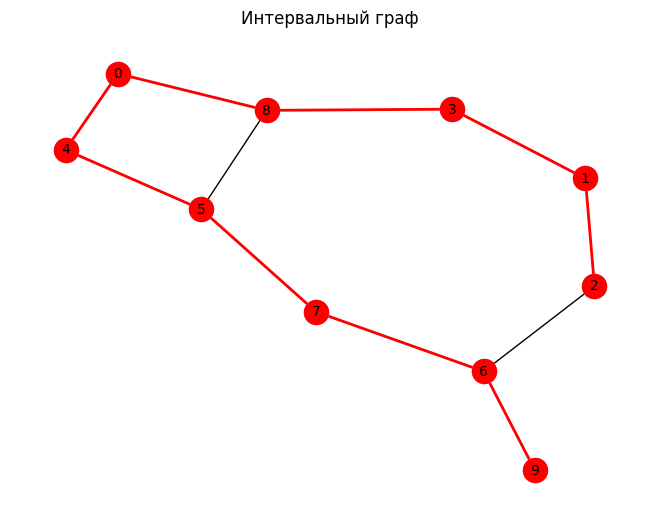

In [7]:
G = nx.Graph()
G.add_nodes_from(range(len(graph.intervals)))
for i, interval in enumerate(graph.intervals):
    G.nodes[i]['label'] = f'[{interval[0]:.2f}, {interval[1]:.2f}]'
for i in range(len(graph.intervals)):
    for j in graph.adj_list[i]:
        G.add_edge(i, j)

longest_path, longest_length = find_longest_path_BF(graph)

print("Самый длинный путь:")
print(longest_path)
print("Длина самого длинного пути:")
print(longest_length)
        
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=10)

plt.title("Интервальный граф")
plt.show()

G = nx.Graph()
G.add_nodes_from(range(len(graph.intervals)))
for i, interval in enumerate(graph.intervals):
    G.nodes[i]['label'] = f'[{interval[0]:.2f}, {interval[1]:.2f}]'
for i in range(len(graph.intervals)):
    for j in graph.adj_list[i]:
        G.add_edge(i, j)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=10)

# Подсветка самого длинного пути
nx.draw_networkx_nodes(G, pos, nodelist=longest_path, node_color='red', node_size=300)
nx.draw_networkx_edges(G, pos, edgelist=[(longest_path[i], longest_path[i + 1]) for i in range(len(longest_path) - 1)], edge_color='red', width=2)

plt.title("Интервальный граф")
plt.show()

In [8]:
def measure_algorithm_performance(num_graphs_per_size, graph_sizes):
    results = {}
    
    for size in graph_sizes:
        total_time = 0
        
        for _ in range(num_graphs_per_size):
            graph = generate_intervals(size, 10)
            
            start_time = time.time()
            find_longest_path_BF(graph)
            end_time = time.time()
            
            total_time += end_time - start_time
        
        average_time = total_time / num_graphs_per_size
        results[size] = average_time
    
    return results

num_graphs_per_size = 20
graph_sizes = range(3, 13)

performance_results = measure_algorithm_performance(num_graphs_per_size, graph_sizes)

for size, time_taken in performance_results.items():
    print(f"Среднее время выполнения для графов размером {size}: {time_taken} секунд")

Среднее время выполнения для графов размером 3: 0.0 секунд
Среднее время выполнения для графов размером 4: 0.0 секунд
Среднее время выполнения для графов размером 5: 0.00017896890640258789 секунд
Среднее время выполнения для графов размером 6: 0.00026090145111083983 секунд
Среднее время выполнения для графов размером 7: 0.0013851284980773925 секунд
Среднее время выполнения для графов размером 8: 0.01222681999206543 секунд
Среднее время выполнения для графов размером 9: 0.10986602306365967 секунд
Среднее время выполнения для графов размером 10: 2.15284925699234 секунд
Среднее время выполнения для графов размером 11: 24.324495458602904 секунд
Среднее время выполнения для графов размером 12: 404.46415828466417 секунд


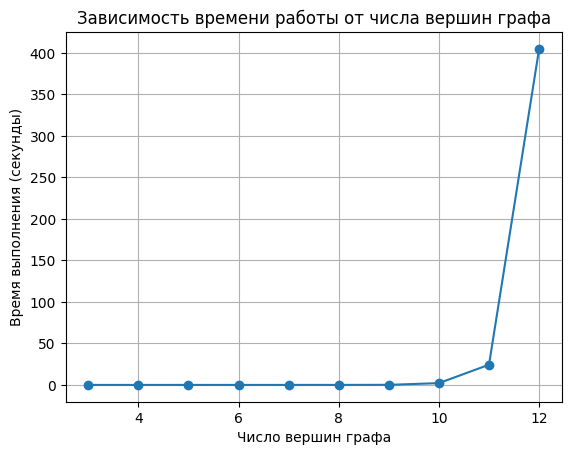

In [10]:
graph_sizes = list(performance_results.keys())
execution_times = list(performance_results.values())

# Построение графика
plt.plot(graph_sizes, execution_times, marker='o', linestyle='-')
plt.title('Зависимость времени работы от числа вершин графа')
plt.xlabel('Число вершин графа')
plt.ylabel('Время выполнения (секунды)')
plt.grid(True)
plt.show()

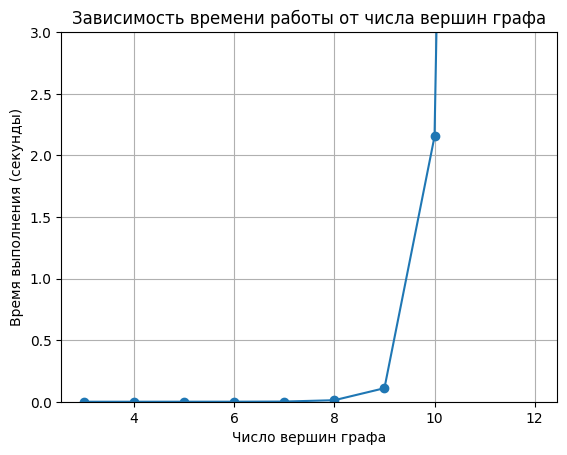

In [48]:
graph_sizes = list(performance_results.keys())
execution_times = list(performance_results.values())

plt.plot(graph_sizes, execution_times, marker='o', linestyle='-')
plt.title('Зависимость времени работы от числа вершин графа')
plt.xlabel('Число вершин графа')
plt.ylabel('Время выполнения (секунды)')
plt.grid(True)
plt.ylim(0, 3)
plt.show()

Теперь сгенерируем граф для работы с более продвинутыми методами решения задачи о самом длинном пути

In [11]:
num_intervals = random.randint(30, 50)
graph = generate_intervals(num_intervals, 10)

[0, 34, 20, 40, 17, 2, 1, 11, 36, 43, 39, 32, 9, 25, 46, 28, 48, 27, 16, 18, 3, 4, 37, 31, 26, 44, 19, 12, 8, 6, 14, 47]


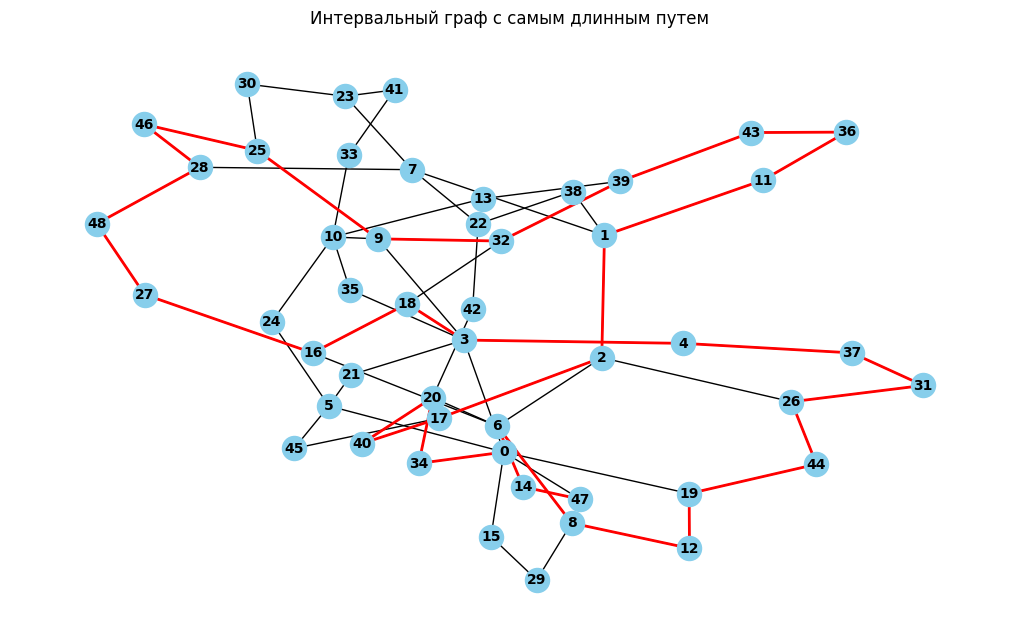

In [12]:
longest_path_result = longest_path_dfs(graph)
longest_intervals = [graph.intervals[node] for node in longest_path_result]

print(longest_path_result)

G = nx.Graph()
G.add_nodes_from(range(len(graph.intervals)))
for i in range(len(graph.intervals)):
    for j in graph.adj_list[i]:
        G.add_edge(i, j)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=[(longest_path_result[i], longest_path_result[i + 1]) for i in range(len(longest_path_result) - 1)], edge_color='red', width=2)
plt.title('Интервальный граф с самым длинным путем')
plt.show()

In [13]:
longest_path, longest_length = branch_and_bound_2(graph)

print("Самый длинный путь:")
print(longest_path)

Самый длинный путь:
[0, 34, 20, 42, 22, 7, 28, 48, 27, 16, 18, 32, 9, 25, 30, 23, 41, 33, 10, 13, 39, 43, 36, 11, 1, 2, 17, 45, 5, 21, 3, 4, 37, 31, 26, 44, 19, 12, 8, 6, 14, 47]
Длина самого длинного пути:
80.19565929673847


In [14]:
longest_path, longest_length = greedy_longest_path_2(graph)

print("Самый длинный путь (жадный алгоритм):")
print(longest_path)

Самый длинный путь (жадный алгоритм):
[31, 26, 2, 6, 20, 40, 17, 45, 5, 0, 3, 9, 10, 33, 41, 23, 7, 1, 11, 36, 43, 39, 32, 18, 16, 27, 48, 28, 46, 25, 30]
Длина самого длинного пути (жадный алгоритм):
31


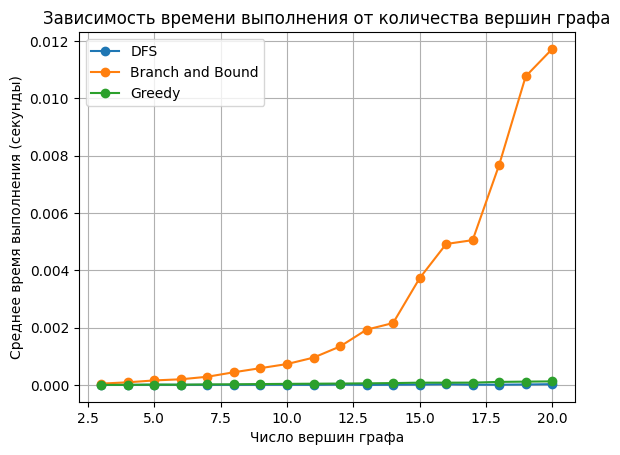

In [15]:
def measure_algorithm_performance(algorithm, num_graphs, min_size, max_size):
    performance_results = {}

    for size in range(min_size, max_size + 1):
        total_execution_time = 0

        for _ in range(num_graphs):
            graph = generate_intervals(size, 10)
            start_time = time.time()
            algorithm(graph)
            end_time = time.time()
            total_execution_time += end_time - start_time

        average_execution_time = total_execution_time / num_graphs
        performance_results[size] = average_execution_time

    return performance_results



num_graphs = 1000
min_size = 3
max_size = 20

# Измерение производительности для каждого метода
dfs_performance = measure_algorithm_performance(longest_path_dfs, num_graphs, min_size, max_size)
plt.plot(list(dfs_performance.keys()), list(dfs_performance.values()), label='DFS', marker='o')
bb_performance = measure_algorithm_performance(branch_and_bound_2, num_graphs, min_size, max_size)
plt.plot(list(bb_performance.keys()), list(bb_performance.values()), label='Branch and Bound', marker='o')
greedy_performance = measure_algorithm_performance(greedy_longest_path_2, num_graphs, min_size, max_size)

# Визуализация результатов
plt.plot(list(greedy_performance.keys()), list(greedy_performance.values()), label='Greedy', marker='o')

plt.xlabel('Число вершин графа')
plt.ylabel('Среднее время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вершин графа')
plt.legend()
plt.grid(True)
plt.show()

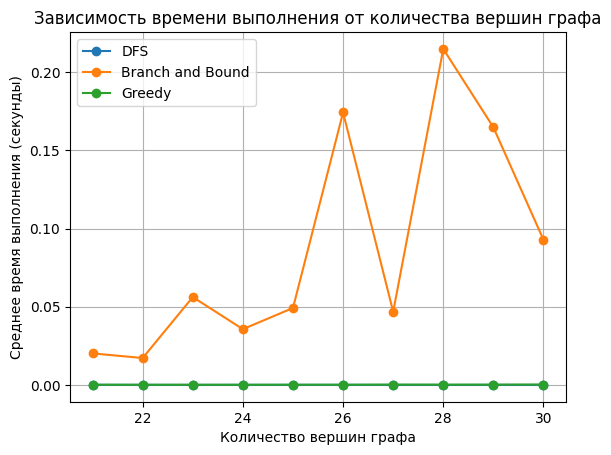

In [19]:
num_graphs = 100
min_size = 21
max_size = 30

dfs_performance_1 = measure_algorithm_performance(longest_path_dfs, num_graphs, min_size, max_size)
bb_performance_1 = measure_algorithm_performance(branch_and_bound_2, num_graphs, min_size, max_size)
greedy_performance_1 = measure_algorithm_performance(greedy_longest_path_2, num_graphs, min_size, max_size)

plt.plot(list(dfs_performance_1.keys()), list(dfs_performance_1.values()), label='DFS', marker='o')
plt.plot(list(bb_performance_1.keys()), list(bb_performance_1.values()), label='Branch and Bound', marker='o')
plt.plot(list(greedy_performance_1.keys()), list(greedy_performance_1.values()), label='Greedy', marker='o')

plt.xlabel('Количество вершин графа')
plt.ylabel('Среднее время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вершин графа')
plt.legend()
plt.grid(True)
plt.show()

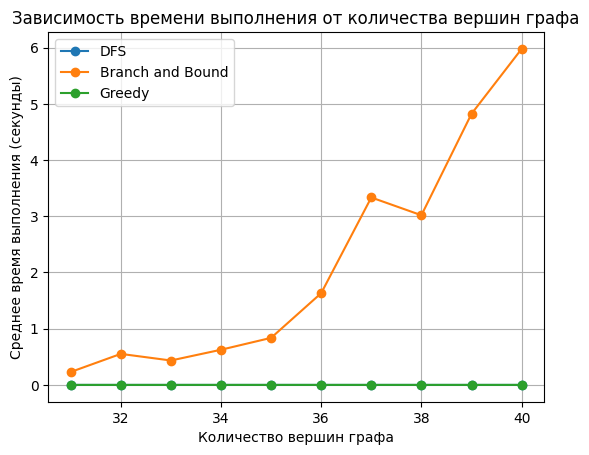

In [23]:
num_graphs = 100
min_size = 31
max_size = 40

dfs_performance_2 = measure_algorithm_performance(longest_path_dfs, num_graphs, min_size, max_size)
bb_performance_2 = measure_algorithm_performance(branch_and_bound_2, num_graphs, min_size, max_size)
greedy_performance_2 = measure_algorithm_performance(greedy_longest_path_2, num_graphs, min_size, max_size)

plt.plot(list(dfs_performance_2.keys()), list(dfs_performance_2.values()), label='DFS', marker='o')
plt.plot(list(bb_performance_2.keys()), list(bb_performance_2.values()), label='Branch and Bound', marker='o')
plt.plot(list(greedy_performance_2.keys()), list(greedy_performance_2.values()), label='Greedy', marker='o')

plt.xlabel('Количество вершин графа')
plt.ylabel('Среднее время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вершин графа')
plt.legend()
plt.grid(True)
plt.show()

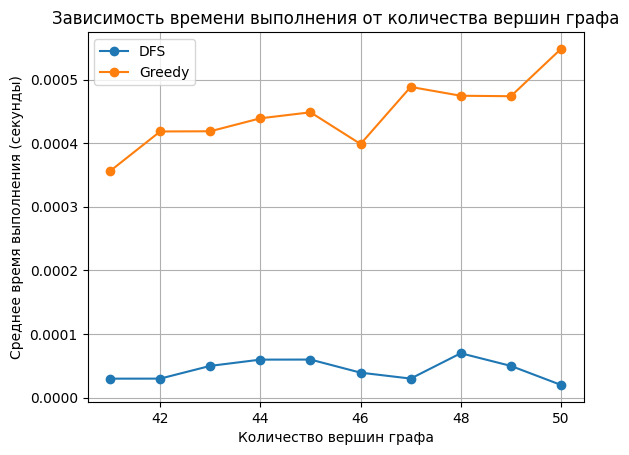

In [27]:
num_graphs = 100
min_size = 41
max_size = 50

dfs_performance_3 = measure_algorithm_performance(longest_path_dfs, num_graphs, min_size, max_size)

greedy_performance_3 = measure_algorithm_performance(greedy_longest_path_2, num_graphs, min_size, max_size)

plt.plot(list(dfs_performance_3.keys()), list(dfs_performance_3.values()), label='DFS', marker='o')

plt.plot(list(greedy_performance_3.keys()), list(greedy_performance_3.values()), label='Greedy', marker='o')

plt.xlabel('Количество вершин графа')
plt.ylabel('Среднее время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вершин графа')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
dfs_performance_end = {
    **dfs_performance,
    **dfs_performance_1,
    **dfs_performance_2,
    **dfs_performance_3
}

bb_performance_end = {
    **bb_performance,
    **bb_performance_1,
    **bb_performance_2
}

greedy_performance_end = {
    **greedy_performance,
    **greedy_performance_1,
    **greedy_performance_2,
    **greedy_performance_3
}

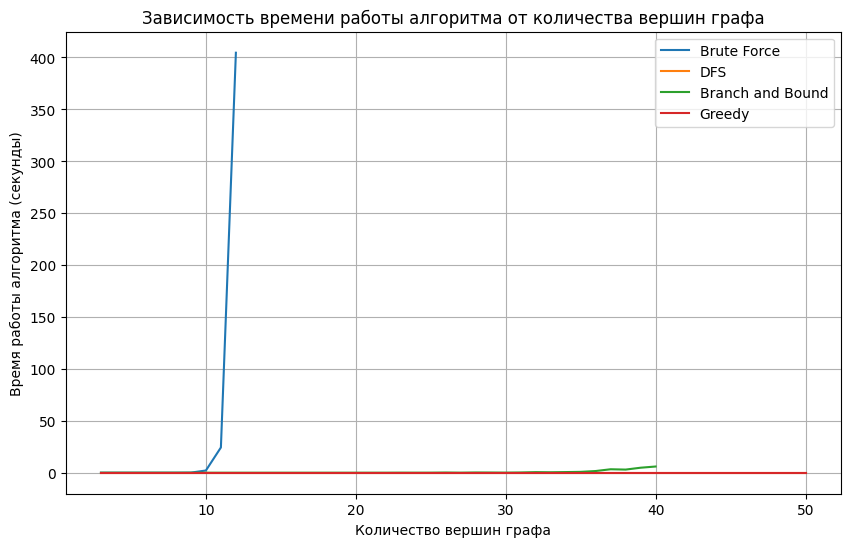

In [29]:
plt.figure(figsize=(10, 6))

plt.plot(list(performance_results.keys()), list(performance_results.values()), label='Brute Force')
plt.plot(list(dfs_performance_end.keys()), list(dfs_performance_end.values()), label='DFS')
plt.plot(list(bb_performance_end.keys()), list(bb_performance_end.values()), label='Branch and Bound')
plt.plot(list(greedy_performance_end.keys()), list(greedy_performance_end.values()), label='Greedy')

plt.xlabel('Количество вершин графа')
plt.ylabel('Время работы алгоритма (секунды)')
plt.title('Зависимость времени работы алгоритма от количества вершин графа')
plt.legend()

plt.grid(True)
plt.show()

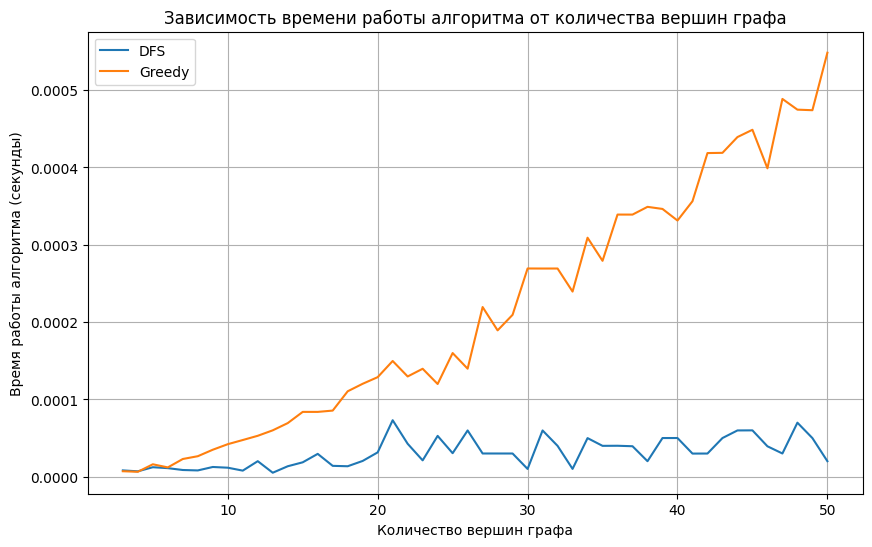

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(list(dfs_performance_end.keys()), list(dfs_performance_end.values()), label='DFS')
plt.plot(list(greedy_performance_end.keys()), list(greedy_performance_end.values()), label='Greedy')

plt.xlabel('Количество вершин графа')
plt.ylabel('Время работы алгоритма (секунды)')
plt.title('Зависимость времени работы алгоритма от количества вершин графа')
plt.legend()

plt.grid(True)
plt.show()

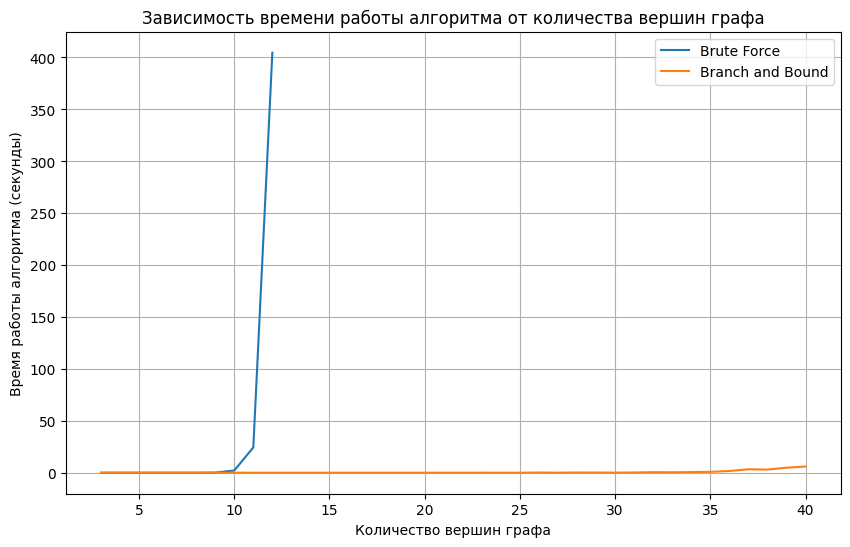

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(list(performance_results.keys()), list(performance_results.values()), label='Brute Force')
plt.plot(list(bb_performance_end.keys()), list(bb_performance_end.values()), label='Branch and Bound')

plt.xlabel('Количество вершин графа')
plt.ylabel('Время работы алгоритма (секунды)')
plt.title('Зависимость времени работы алгоритма от количества вершин графа')
plt.legend()

plt.grid(True)
plt.show()

In [32]:
num_graphs = 10000
min_size = 3
max_size = 200

dfs_performance_exp = measure_algorithm_performance(longest_path_dfs, num_graphs, min_size, max_size)

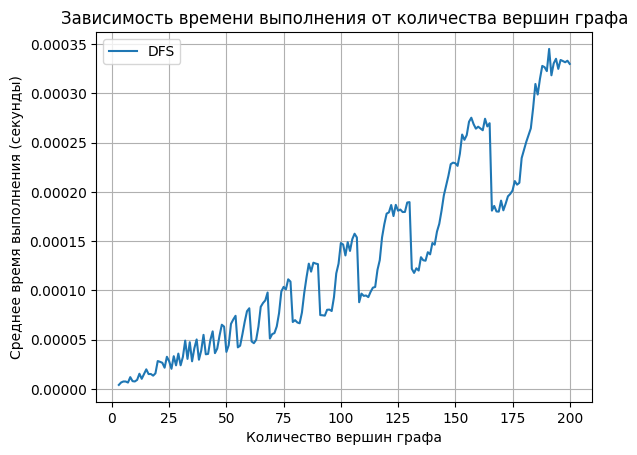

In [33]:
plt.plot(list(dfs_performance_exp.keys()), list(dfs_performance_exp.values()), label='DFS')

plt.xlabel('Количество вершин графа')
plt.ylabel('Среднее время выполнения (секунды)')
plt.title('Зависимость времени выполнения от количества вершин графа')
plt.legend()
plt.grid(True)
plt.show()

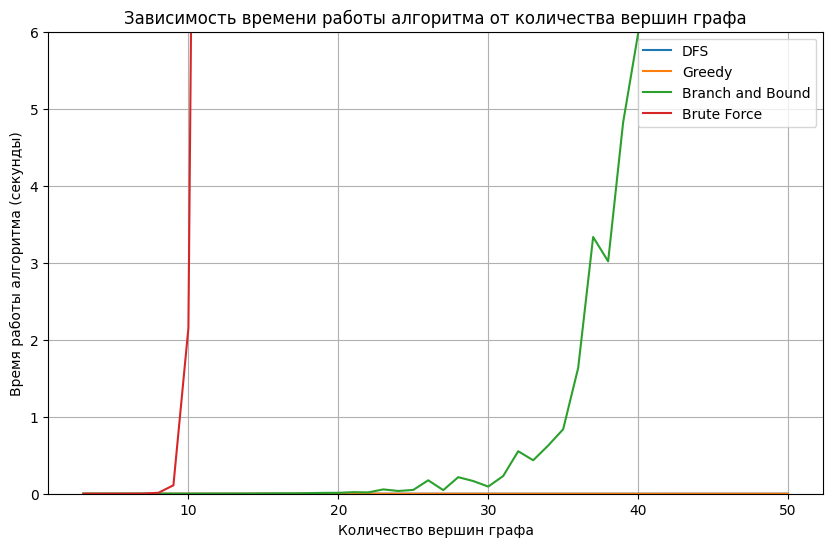

In [44]:
plt.figure(figsize=(10, 6))

plt.plot(list(dfs_performance_end.keys()), list(dfs_performance_end.values()), label='DFS')
plt.plot(list(greedy_performance_end.keys()), list(greedy_performance_end.values()), label='Greedy')
plt.plot(list(bb_performance_end.keys()), list(bb_performance_end.values()), label='Branch and Bound')
plt.plot(list(performance_results.keys()), list(performance_results.values()), label='Brute Force')

plt.xlabel('Количество вершин графа')
plt.ylabel('Время работы алгоритма (секунды)')
plt.title('Зависимость времени работы алгоритма от количества вершин графа')
plt.legend()
plt.ylim(0, 6)
plt.grid(True)
plt.show()

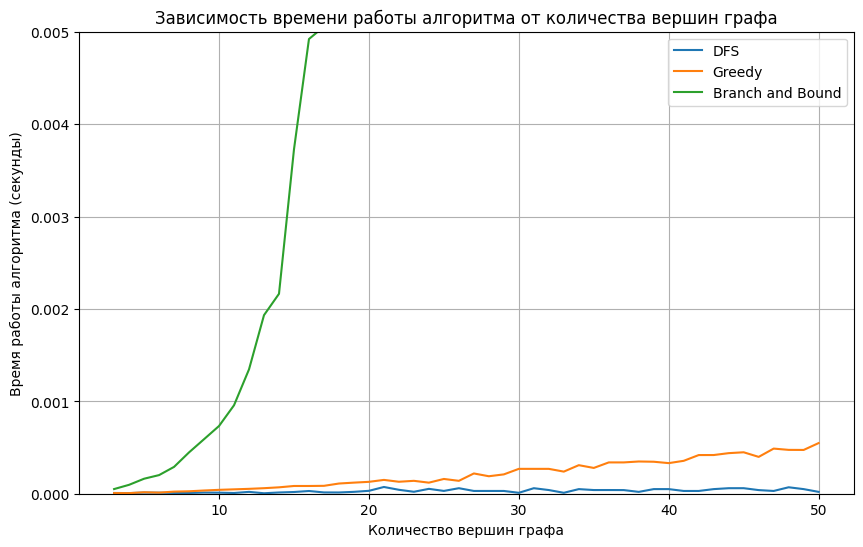

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(list(dfs_performance_end.keys()), list(dfs_performance_end.values()), label='DFS')
plt.plot(list(greedy_performance_end.keys()), list(greedy_performance_end.values()), label='Greedy')
plt.plot(list(bb_performance_end.keys()), list(bb_performance_end.values()), label='Branch and Bound')

plt.xlabel('Количество вершин графа')
plt.ylabel('Время работы алгоритма (секунды)')
plt.title('Зависимость времени работы алгоритма от количества вершин графа')
plt.legend()

plt.ylim(0, 0.005)

plt.grid(True)
plt.show()
